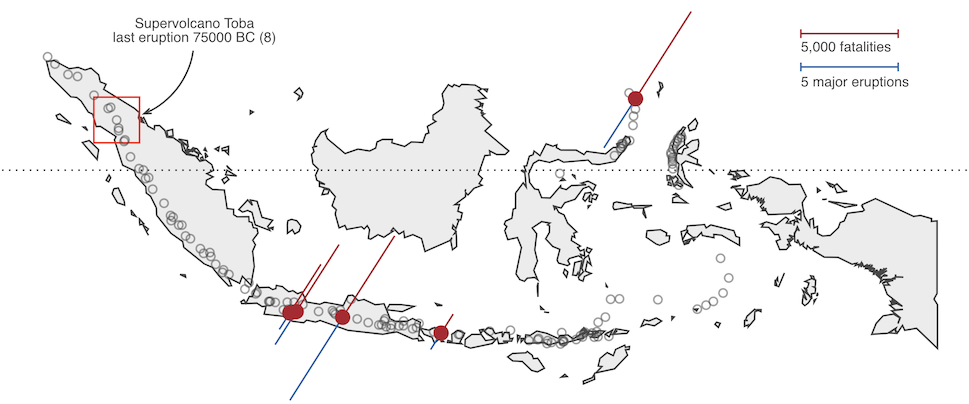

In [ ]:
# !pip install lets-plot --quiet

## Introduction

Indonesia, a nation known for its stunning natural landscapes and vast archipelago, is home 
to some of the world's most active and remarkable volcanoes. 

Situated along the **Pacific Ring of Fire**, Indonesia boasts a staggering number of volcanic peaks,
each with its own unique geological history and cultural significance.

From the towering majesty of _Mount Merapi_ to the tranquil beauty of _Mount Rinjani_,
these volcanoes have shaped the land and the lives of those who call Indonesia home.

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

from lets_plot import *
from lets_plot.mapping import as_discrete
from lets_plot import tilesets            # Tilesets for the map.
from lets_plot.geo_data import *          # Geo-coding

LetsPlot.setup_html()

In [ ]:
import lets_plot
lets_plot.__version__

## Volcanoes and Geo-locations

Volcano coordinates are given in DMS format and should be converted </br>
to decimal degrees for plotting on a map.

In [ ]:
df_volc = pd.read_csv("Data/volcano_indo.csv", encoding ='utf-8')
df_volc.head(3)

In [ ]:
def dms_to_decimal(dms_string):
    """
    Convert DMS coordinates to decimal degrees.
    
    >>> dms_to_decimal("99.539°E")
    99.539
    
    >>> dms_to_decimal("99.539°W")
    -99.539
    
    """
    degrees, direction = dms_string.split('°')
    degrees = float(degrees)
    
    # Adjusting the sign based on direction
    if direction in ['S', 'W']:
        degrees *= -1
    
    return degrees


In [ ]:
df_volc = df_volc.dropna(subset=['Geo_Location'])

# Split 'Geo_Location' str.
lat_lon_dms = df_volc.Geo_Location.str.split(' ').apply(lambda lst: lst[1:3])

# Remove BOM symbols (\ufeff) and
# convert DMS strings to decimal degrees.
lat_lon_dd = lat_lon_dms.apply(lambda lst: [dms_to_decimal(v.replace('\ufeff', '')) for v in lst])

# Create a Geodataframe by adding the 'geometry' column.
latitudes = lat_lon_dd.apply(lambda pair: pair[0])
longitudes = lat_lon_dd.apply(lambda pair: pair[1])

gdf_volc = gpd.GeoDataFrame(df_volc, geometry=gpd.points_from_xy(longitudes, latitudes))
gdf_volc.head(3)

In [ ]:
gdf_superv = gdf_volc[gdf_volc.Shape == "supervolcano"]
gdf_superv


## Volcanoes on Map

In [ ]:
common_theme = theme(plot_title=element_text(family='bold', size=20, hjust=0.5, color='#1a1a1a'))

# Toba is a super-volcano
gdf_toba = gdf_volc[gdf_volc.Name == "Toba"]
toba = gdf_toba.geometry.iloc[0]
toba_le = gdf_toba.Last_Eruption.iloc[0] 

In [ ]:
(ggplot() + geom_livemap(tiles=tilesets.NASA_COLOR_SHADED_RELIEF_30M) 
  # Equator
  + geom_hline(yintercept=0, linetype="dotted", color='white', tooltips=layer_tooltips().line('Equator'))

  # Show supervolcano Toba.
  + geom_point(data=gdf_superv, shape=0, color="red", size=20) 
  + geom_curve(x=toba.x + 4, 
               y=toba.y + 4, 
               xend=toba.x, 
               yend=toba.y,
               size_start=8, 
               size_end=23, 
               curvature=-0.4, 
               arrow=arrow(angle=20, length=8, type='open', ends='last'),
               color="white") 
  + geom_text(x=toba.x + 4, y=toba.y + 4,
              label="Supervolcano Toba\nlast eruption " + toba_le, 
              vjust='bottom',
              color="white") 
 
  # Add other volcanoes.
  + geom_point(data=gdf_volc, shape=1, color="yellow", tooltips=layer_tooltips()
               .title("@Name\n(@Shape)") 
               .line("@Geo_Location")
               .line("@Elevation")
               .line("Last Eruption | @Last_Eruption")
              ) 

  + ggtitle("Volcanoes of Indonesia") + common_theme
  + ggsize(1000, 750))

## Volcanic Activity and Fatalities

In [ ]:
df_erupt = pd.read_csv("Data/Major_eruption.csv", encoding ='utf-8')
df_erupt.head(3)

### Major Eruptions

In [ ]:
(ggplot(df_erupt) 
     + geom_bar(aes(x=as_discrete('Volcano', order_by='..count..', order=1)),
                fill="#ef8a62",
                labels=layer_labels(['..count..']).format('..count..', 'd')) 
     + coord_flip() + labs(y="Number of Major Eruptions on Record"))

### Fatalities Caused by Volcanic Activity

In [ ]:
# Cleanup "Fatality"

# Remove Toba.
df_erupt = df_erupt[df_erupt.Volcano != 'Toba']

# Drop n/a values.
df_erupt = df_erupt.dropna(subset=['Fatality']).copy()

#
# Convert string values to numbers.
#
import re

# Define a function to remove non-numeric symbols.
clean_numeric = lambda x: re.sub(r'\D', '', x) if isinstance(x, str) else str(x)

# Cleanup strings.
df_erupt['Fatality'] = df_erupt['Fatality'].apply(clean_numeric)

# str -> number
df_erupt['Fatality'] = pd.to_numeric(df_erupt['Fatality'])

# Remove uninformative records
df_erupt = df_erupt[df_erupt.Fatality > 0].copy()


In [ ]:
(ggplot(df_erupt) 
 + geom_bar(aes(x=as_discrete('Volcano', order_by='..count..', order=1), weight='Fatality'),
                fill="#ef8a62",
                labels=layer_labels(['..count..'])) 
 + labs(y='Fatalities Caused by Volcanic Activity')
 + coord_flip() + ggsize(1000, 300))

### Major Eruptions and Fatalities Side-by-Side

In [ ]:
# Create a list of volcanoes ordered by the count of fatalities.

# Group by "Volcano" column and sum the "Fatality" column
volcano_fatality_sum = df_erupt.groupby('Volcano')['Fatality'].sum().reset_index()

# Sort the resulting DataFrame by the sum of fatalities in descending order
sorted_volcanoes = volcano_fatality_sum.sort_values(by='Fatality', ascending=False)
names_sorted = sorted_volcanoes.Volcano.to_list()


In [ ]:
# Ensure that the "Fatalities" and "Eruptions" plots display volcanoes in the same order

p_fatalities = (ggplot(df_erupt) 
 + geom_bar(aes(y=as_discrete('Volcano', levels=names_sorted), weight='Fatality'),
            fill="#67001f",
            labels=layer_labels(['..count..']),
            orientation="y"
           ) 
 + ggtitle("Fatalities Caused by Volcanic Activity")               
 + theme_void() 
 + theme(plot_title=element_text(family='bold', size=20, hjust=0.5, color='#67001f'))
)


In [ ]:
p_eruptions = (ggplot(df_erupt) 
 + geom_bar(aes(y=as_discrete('Volcano', levels=names_sorted)),
            fill="#fddbc7",
            labels=layer_labels(['..count..']).format('..count..', 'd'),
            orientation="y"
            ) 
 + ggtitle("Major Eruptions")               
 + scale_x_reverse() 
 + scale_y_discrete(position="right") 
 + theme_void() 
 + theme(
     axis_text_y=element_text(),
     plot_title=element_text(family='bold', size=20, hjust=0.5, color='#1a1a1a'))
)


In [ ]:
gggrid([
    p_eruptions, 
    p_fatalities
], widths=[2, 5]) + ggsize(1000, 400)


## Volcanic Activity on Map

In [ ]:
# Convert GeoDataframe to a regular one with `lon/lat` columns.
gd_volc_xy = gdf_volc.copy()
gd_volc_xy['lon'] = gd_volc_xy.geometry.x
gd_volc_xy['lat'] = gd_volc_xy.geometry.y
gd_volc_xy = gd_volc_xy.drop(columns=['geometry'])


# Add coordinates to the "Eruptions" dataset.
df_erupt_xy = pd.merge(df_erupt, gd_volc_xy, left_on='Volcano', right_on='Name', how='inner')
df_erupt_xy = df_erupt_xy.drop(columns=['Name'])

# Add eruption count the "Eruptions" dataset.
#  - Count unique values in "Volcano" column
volcano_counts = df_erupt_xy['Volcano'].value_counts()
#  - Map the counts back to the original DataFrame
df_erupt_xy['Erupt_count'] = df_erupt_xy['Volcano'].map(volcano_counts)

In [ ]:
# Sum "Fatality" per volcano
df_erupt_xy_agg = df_erupt_xy.groupby('Volcano').agg({
    'Fatality': 'sum',
    'Eruption date': 'last',
    'Erupt_count': 'first',
    'lon': 'first',
    'lat': 'first'
}).reset_index()


# Work-around for `scale_radius` bug.
df_erupt_xy_agg['Fatality/1000'] = df_erupt_xy_agg['Fatality'] / 1000

In [ ]:
# Indonesia's polygon (geocoder object).
indonesia_gcoder = geocode_countries('indonesia')

(ggplot() + geom_map(map=indonesia_gcoder) 
  # Equator
  + geom_hline(yintercept=0, linetype="dotted", tooltips='none')

  # Supervolcano Toba.
  + geom_point(data=gdf_superv, shape=0, color="red", size=20) 
  + geom_curve(x=toba.x + 4, 
               y=toba.y + 4, 
               xend=toba.x, 
               yend=toba.y,
               size_start=8, 
               size_end=23, 
               curvature=-0.4, 
               arrow=arrow(angle=20, length=8, type='open', ends='last')) 
  + geom_text(x=toba.x + 4, y=toba.y + 4,
              label="Supervolcano Toba\nlast eruption " + toba_le, 
              vjust='bottom',
              ) 
 
  # Add all volcanoes but not too much contrast. 
  + geom_point(data=gdf_volc, color='#fddbc7', tooltips=layer_tooltips()
               .title("@Name") 
               .line("Last Eruption | @Last_Eruption"))
 
  # Eruptions count bars. 
  + geom_spoke(aes('lon', 'lat', radius='Erupt_count'), data=df_erupt_xy_agg, color="#2166ac", angle=4.14,
               tooltips=layer_tooltips()
                   .title("@Volcano\n@Erupt_count major eruptions") 
                   .line("Last Eruption | @{Eruption date}")
                   .format('Erupt_count', 'd')
              )
  # Fatalities count bars. 
  + geom_spoke(aes('lon', 'lat', radius='Fatality/1000'), data=df_erupt_xy_agg, color="#b2182b", angle=1, 
               tooltips=layer_tooltips()
                   .title("@Volcano\n@Fatality fatalities") 
                   .line("Last Eruption | @{Eruption date}")
              )
 
  # Locations of active volcanoes.
  + geom_point(aes('lon', 'lat'), data=df_erupt_xy_agg, color="#b2182b", size=7,
               tooltips=layer_tooltips()
                   .title("@Volcano\n@Fatality fatalities") 
                   .line("Last Eruption | @{Eruption date}")) 
 
  # The Key
  + geom_errorbar(y=7, xmin=134, xmax=139, color="#b2182b") + geom_text(label="5,000 fatalities", x=134, y=7, vjust='top', hjust='left',nudge_y=-0.4)
  + geom_errorbar(y=5.3, xmin=134, xmax=139, color="#2166ac") + geom_text(label="5 major eruptions", x=134, y=5.2, vjust='top', hjust='left',nudge_y=-0.4)
  + ggtitle("Indonesia's Volcanic Activity and Fatalities")
  + theme_void() + common_theme + ggsize(1000, 550)) 